In [12]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

/opt/miniconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Подготовка данных

## Загрузка данных

In [2]:
Data = pd.read_csv("../Probe_Data/Febraury_PredData.csv", index_col=0)

In [3]:
def SetShiftTarget(Data, delta):
    """
    Сдвигает изначальный таргет на delta шагов назад
    Шаг дискретизации по времени : 5 минут
    """
    Data['shift_target'] = Data.target.shift(-delta).values
    Data.fillna(0, inplace=True)
    return Data

In [4]:
Data = SetShiftTarget(Data, 36)

In [5]:
Val_Data = Data.loc[:"2020-02-20"]
Exam_Data = Data.loc["2020-02-20":]

X = Val_Data.drop(['target', 'shift_target'], axis=1)
y = Val_Data['shift_target']

Exam_X = Exam_Data.drop(['target', 'shift_target'], axis=1)
Exam_Y = Exam_Data['shift_target']

## Дополнение входных данных оконными корреляциями между датчиками

In [6]:
WINDOW_SIZE = 20

corr_X = X.rolling(window = WINDOW_SIZE).corr()
Exam_corr_X = Exam_X.rolling(window = WINDOW_SIZE).corr()

In [7]:
from itertools import product, combinations

Sensors_Combs = list(combinations(X.columns, r=2))

CorrFeatures = pd.DataFrame()
ExamCorrFeatures = pd.DataFrame()

for sens_1, sens_2 in Sensors_Combs:

    # Выбираем из датафрейма, корреляцию за все время пары датчиков `sens_1` и `sens_2`
    corr_series = corr_X[sens_1].loc[:, sens_2]
    exam_corr_series = Exam_corr_X[sens_1].loc[:, sens_2]

    # Так как использовалась оконная функция в начале есть пропуски
    # Заполним их случайными величинами из диапазона [MIN, MAX] для данного ряда
    MAX, MIN = corr_series.max(), corr_series.min()
    fill_values = np.random.sample(size=WINDOW_SIZE - 1) * (MAX - MIN) + MIN
    corr_series[:WINDOW_SIZE - 1] = fill_values

    MAX, MIN = exam_corr_series.max(), exam_corr_series.min()
    fill_values = np.random.sample(size=WINDOW_SIZE - 1) * (MAX - MIN) + MIN
    exam_corr_series[:WINDOW_SIZE - 1] = fill_values

    # Все такие новые колонки с попарными корреляциями датчиков
    # Будут начинаться с `Corr_`
    corr_series.name = '_'.join(['Corr', sens_1, sens_2])
    exam_corr_series.name = '_'.join(['Corr', sens_1, sens_2])

    CorrFeatures = pd.concat([CorrFeatures, corr_series], axis=1)
    ExamCorrFeatures = pd.concat([ExamCorrFeatures, exam_corr_series], axis=1)

/opt/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/series.py:1042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(key, value)
/opt/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [8]:
X = pd.concat([X, CorrFeatures], axis=1)
Exam_X = pd.concat([Exam_X, ExamCorrFeatures], axis=1)

## Стандартизация

In [138]:
from sklearn.preprocessing import StandardScaler

In [139]:
ss = StandardScaler()
ss.fit(X)
X = pd.DataFrame(ss.transform(X), columns=X.columns, index=X.index)
Exam_X = pd.DataFrame(ss.transform(Exam_X),
                      columns=Exam_X.columns,
                      index=Exam_X.index)

<AxesSubplot:>

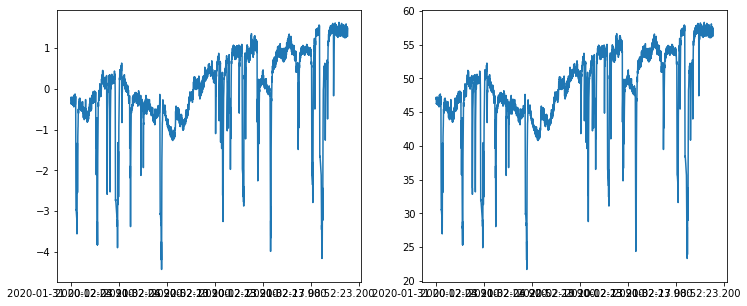

In [140]:
## Просто удостовериться, что форма временного ряда никак не поменялась после преобразования

fig, axes = plt.subplots(1,2, figsize=(12,5))
X['Температура обмотки статора А (датчик №1)'].plot(ax=axes[0])
Val_Data['Температура обмотки статора А (датчик №1)'].plot(ax=axes[1])

<AxesSubplot:>

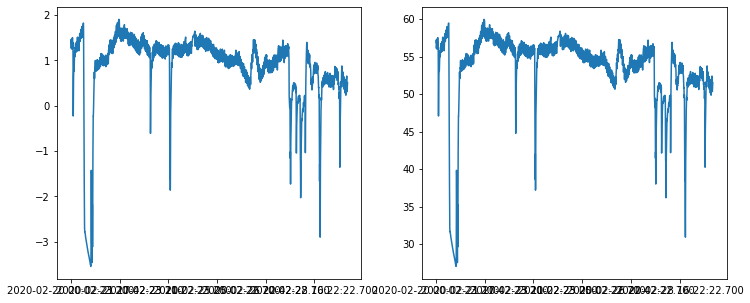

In [141]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
Exam_X['Температура обмотки статора А (датчик №1)'].plot(ax=axes[0])
Exam_Data['Температура обмотки статора А (датчик №1)'].plot(ax=axes[1])

# Классификатор аномалий

In [9]:
from xgboost import XGBRegressor, XGBRFRegressor, XGBClassifier, XGBRFClassifier

## XGBoost Random Forest

In [10]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import roc_auc_score, classification_report

### Подбор параметров на кросс-валидации

In [13]:
from tqdm.notebook import tqdm

Params = {
    "n_estimators": 10,
    "max_depth": 3,
    "booster": 'gbtree',
    "n_jobs": -1
}

N_EST_ARR = range(50, 150, 10)
MAX_DEPTH_ARR = range(2, 13)

param_comb = list(product(N_EST_ARR, MAX_DEPTH_ARR))
best_rec, best_prec, best_f1, best_roc_auc = 0.0, 0.0, 0.0, 0.0
RESULTS = []

for n_est, max_depth in tqdm(param_comb):

    Params['n_estimators'] = n_est
    Params['max_depth'] = max_depth

    CLF = XGBRFClassifier(**Params)
    CV_result = cross_validate(
        CLF,
        X,
        y,
        scoring=['recall', 'precision', 'f1', 'roc_auc'],
        return_train_score=True,
        return_estimator=True)

    #======================================================================#
    # Сохранение результатов и метрик
    #======================================================================#
    res = dict()
    res['params'] = Params

    for part, metric in product(["train", "test"],
                                ["recall", "precision", "f1", "roc_auc"]):
        res[f"{part}_avg_{metric}"] = CV_result[f"{part}_{metric}"].mean()
        res[f"{part}_std_{metric}"] = CV_result[f"{part}_{metric}"].std()

    if res['test_avg_roc_auc'] > best_roc_auc:
        best_roc_auc = res['test_avg_roc_auc']
        best_est = CV_result['estimator']

    RESULTS.append(res)

    #======================================================================#

In [14]:
!telegram-send "Best ROC AUC {best_roc_auc}"

In [15]:
best_n_est = best_est[0].get_params()['n_estimators']
best_max_depth = best_est[0].get_params()['max_depth']
!telegram-send "n_est: {best_n_est}, max_depth: {best_max_depth}"

In [16]:
RESULTS = pd.DataFrame(RESULTS)

<AxesSubplot:title={'center':'Test Score / Train Score'}>

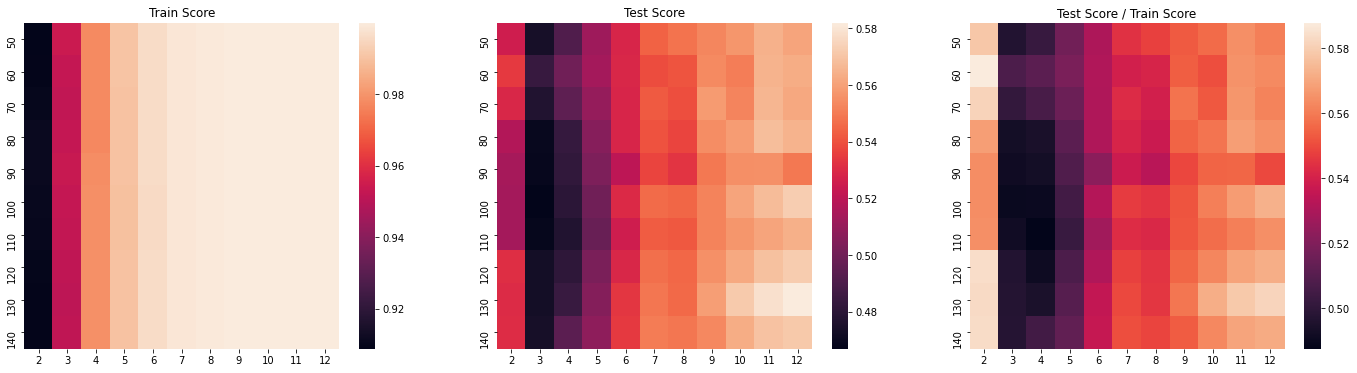

In [17]:
AVG_Train_ROCAUC = RESULTS['train_avg_roc_auc'].values.reshape(
    len(N_EST_ARR), len(MAX_DEPTH_ARR))
AVG_Test_ROCAUC = RESULTS['test_avg_roc_auc'].values.reshape(
    len(N_EST_ARR), len(MAX_DEPTH_ARR))

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

axes[0].set_title("Train Score")
sns.heatmap(AVG_Train_ROCAUC,
            xticklabels=MAX_DEPTH_ARR,
            yticklabels=N_EST_ARR,
            ax=axes[0])

axes[1].set_title("Test Score")
sns.heatmap(AVG_Test_ROCAUC,
            xticklabels=MAX_DEPTH_ARR,
            yticklabels=N_EST_ARR,
            ax=axes[1])

axes[2].set_title("Test Score / Train Score")
sns.heatmap(AVG_Test_ROCAUC / AVG_Train_ROCAUC,
            xticklabels=MAX_DEPTH_ARR,
            yticklabels=N_EST_ARR,
            ax=axes[2])

<div class = "alert alert-block alert-info">

<b>Описание теплокарт выше:</b>
* <b>Ось Х</b> : `max_depth`, максимальная глубина дерева
* <b>Ось Y</b> : `n_estimators`, количество деревьев
* <b>Ось Z</b> : метрика ROC AUC

</div>

---

In [149]:
###================================###
### Опционально : загрузка моделей ###
###================================###

###==========================================================###

import os

LAST_N_MODELS = 5

MODEL_NAMES = sorted(os.listdir(MODELS_DIR),
                     key=lambda x: x[10:])[-LAST_N_MODELS:]

best_est = []
for model_name in MODEL_NAMES:
    clf = XGBRFClassifier()
    clf.load_model(os.path.join(MODELS_DIR, model_name))
    best_est.append(clf)

###==========================================================###

In [18]:
for i, clf in enumerate(best_est):
    Preds = clf.predict(Exam_X)
    ValPreds = clf.predict(X)
    Probs = clf.predict_proba(Exam_X)
    ValProbs = clf.predict_proba(X)

    print(60 * "=")
    print(f"{i+1}-й Классификатор")
    print(60 * "=")

    print("Val Report:\n")
    print(classification_report(y, ValPreds))
    print("Exam Report:\n")
    print(classification_report(Exam_Y, Preds))

1-й Классификатор
Val Report:

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      5539
         1.0       0.99      0.76      0.86       219

    accuracy                           0.99      5758
   macro avg       0.99      0.88      0.93      5758
weighted avg       0.99      0.99      0.99      5758

Exam Report:

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96      2757
         1.0       0.00      0.00      0.00        85

    accuracy                           0.92      2842
   macro avg       0.48      0.47      0.48      2842
weighted avg       0.94      0.92      0.93      2842

2-й Классификатор
Val Report:

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      5539
         1.0       0.74      0.71      0.73       219

    accuracy                           0.98      5758
   macro avg       0.86      0.85      0.86      575

### Сохранение моделей

In [171]:
import os
MODELS_DIR = "./XGBRF_Classifiers_FebrauryLogs/"
# os.mkdir(MODELS_DIR)

In [371]:
## Сохраним модели
import time
time_log = "date_" + '_'.join(map(str,time.localtime()[:3])) + \
           "_time_" + ':'.join(map(str, time.localtime()[3:5]))

for i, clf in enumerate(best_est):
    clf.save_model(os.path.join(MODELS_DIR, f"model_{i}__{time_log}.xgbmodel"))

### Визуализация важности признаков

In [19]:
FeatureImportances = sorted(zip(Exam_X.columns, clf.feature_importances_), 
                            key = lambda x: x[1], reverse=True)

CorrFI = [fi for fi in FeatureImportances if fi[0].startswith('Corr_')]
InitFI = sorted(set(FeatureImportances) - set(CorrFI), key=lambda x: x[1], reverse=True)

#### Отдельно исходные признаки и попарные корреляции

<BarContainer object of 14 artists>

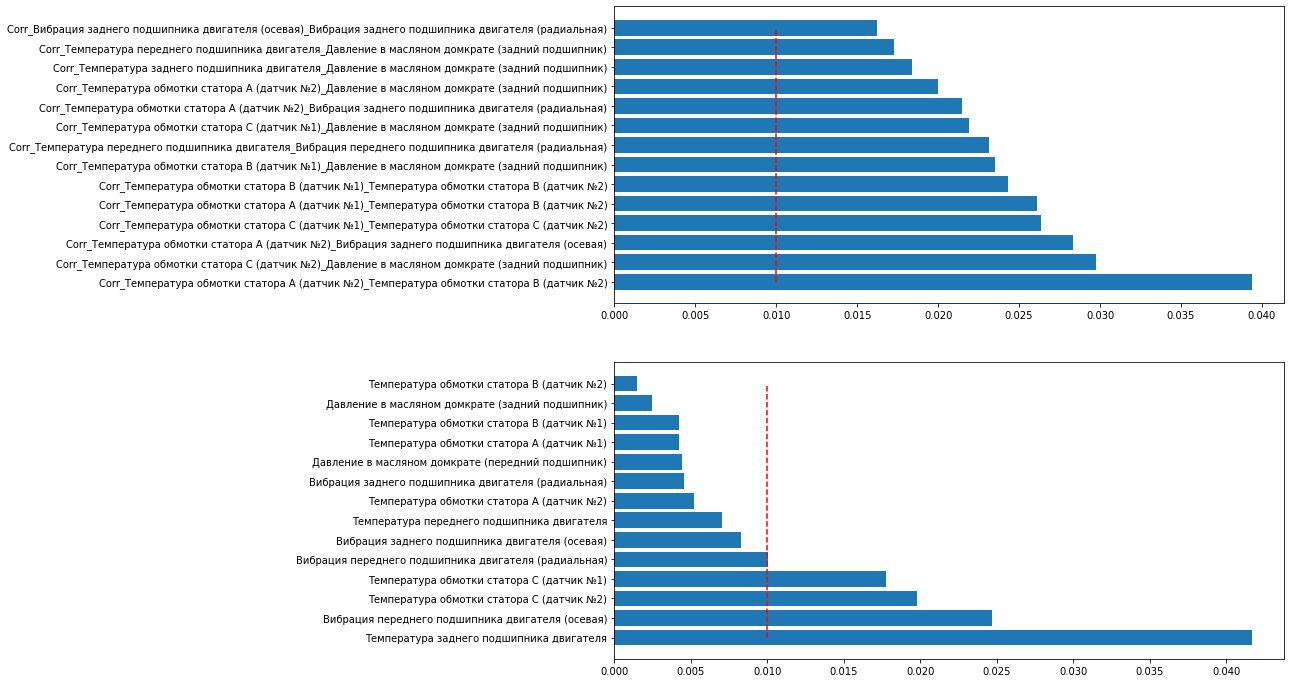

In [20]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

TOP_N = 14

axes[0].vlines(0.01, 1, TOP_N, colors='red', linestyle='dashed')
axes[0].barh(range(1, TOP_N + 1), [fi[1] for fi in CorrFI[:TOP_N]],
             tick_label=[fi[0] for fi in CorrFI[:TOP_N]])

axes[1].vlines(0.01, 1, TOP_N, colors='red', linestyle='dashed')
axes[1].barh(range(1, TOP_N + 1), [fi[1] for fi in InitFI[:TOP_N]],
             tick_label=[fi[0] for fi in InitFI[:TOP_N]])

#### Общий ТОП признаков

<BarContainer object of 28 artists>

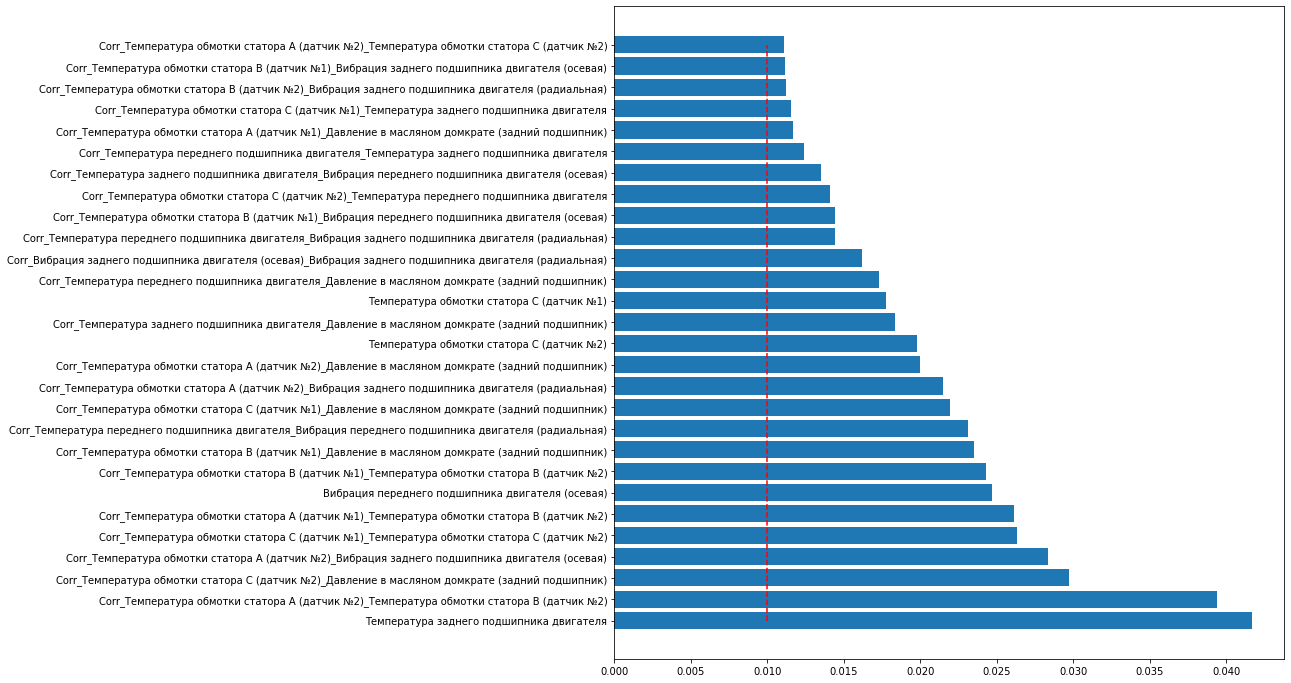

In [21]:
plt.figure(figsize=(12, 12))
plt.vlines(0.01, 1, 2 * TOP_N, colors='red', linestyle='dashed')
plt.barh(range(1, 2 * TOP_N + 1),
         [fi[1] for fi in FeatureImportances[:2 * TOP_N]],
         tick_label=[fi[0] for fi in FeatureImportances[:2 * TOP_N]])

### Визуализация предсказаний

#### Train Part

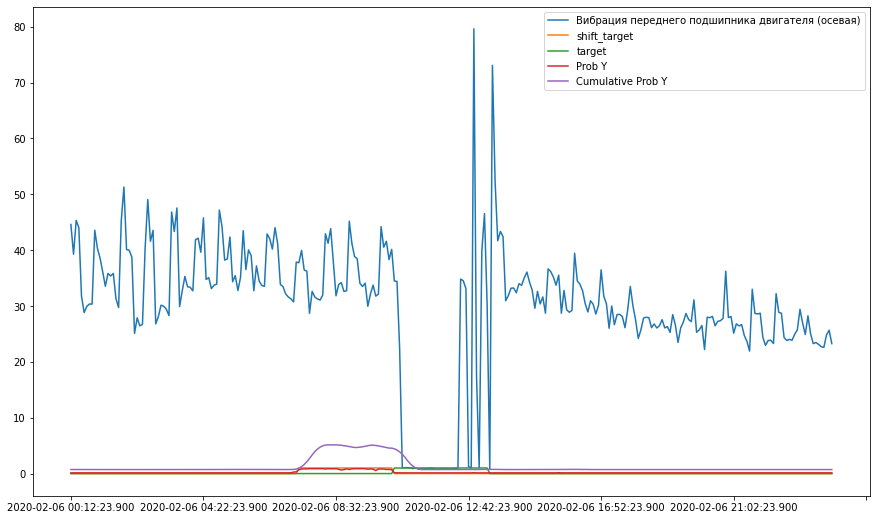

In [22]:
Preds_Series = pd.Series(ValPreds, index=y.index, name='Pred Y')
Probs_Series = pd.Series(ValProbs[:, 1], index=y.index, name='Prob Y')
CumProbs_Series = Probs_Series.rolling(window=6).sum().rolling(window=6).mean()
CumProbs_Series.name = 'Cumulative Prob Y'

plt.figure(figsize=(15, 9))
border = (12 * 288 // 2, 14 * 288 // 2)
X['Вибрация переднего подшипника двигателя (осевая)'][
    border[0]:border[1]].plot()
y[border[0]:border[1]].plot()
Val_Data.target[border[0]:border[1]].plot()
# Preds_Series[border[0]:border[1]].plot()
Probs_Series[border[0]:border[1]].plot()
CumProbs_Series[border[0]:border[1]].plot()

plt.legend()

#### Test Part

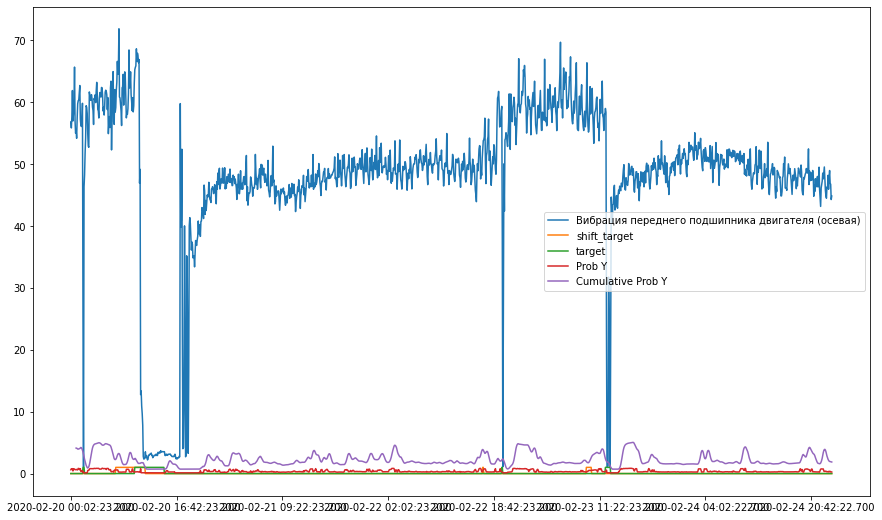

In [23]:
Preds_Series = pd.Series(Preds, index=Exam_Y.index, name='Pred Y')
Probs_Series = pd.Series(Probs[:, 1], index=Exam_Y.index, name='Prob Y')
CumProbs_Series = Probs_Series.rolling(window=6).sum().rolling(window=6).mean()
CumProbs_Series.name = 'Cumulative Prob Y'

plt.figure(figsize=(15, 9))
border = (0 * 288, 5 * 288)
Exam_X['Вибрация переднего подшипника двигателя (осевая)'][
    border[0]:border[1]].plot()
Exam_Y[border[0]:border[1]].plot()
Exam_Data.target[border[0]:border[1]].plot()
# Preds_Series[border[0]:border[1]].plot()
Probs_Series[border[0]:border[1]].plot()
CumProbs_Series[border[0]:border[1]].plot()

plt.legend()

In [181]:
# standard bokeh imports
from bokeh.io import output_notebook, show, reset_output

# other bokeh imports
import bokeh
from bokeh.plotting import figure
# more imports in cells below as needed

# other imports
import numpy as np
import pandas as pd


from ipywidgets import interact, interact_manual
from bokeh.models import HoverTool, Range1d, LinearAxis
from bokeh.layouts import column, row
from bokeh.models import CustomJS, Slider, DateSlider
from bokeh.plotting import ColumnDataSource, figure, output_file, show

In [57]:
output_notebook()

Loading BokehJS ...

In [58]:
SeriesPreds = pd.Series(Preds, index=Exam_Y.index, name='preds')
preds_df = pd.concat([Exam_X, 
                      Exam_Y, 
                      SeriesPreds], axis=1)

In [59]:
preds_df.columns[:15]

Index(['Температура обмотки статора А (датчик №1)',
       'Температура обмотки статора А (датчик №2)',
       'Температура обмотки статора В (датчик №1)',
       'Температура обмотки статора В (датчик №2)',
       'Температура обмотки статора С (датчик №1)',
       'Температура обмотки статора С (датчик №2)',
       'Температура переднего подшипника двигателя',
       'Температура заднего подшипника двигателя',
       'Давление в масляном домкрате (передний подшипник)',
       'Давление в масляном домкрате (задний подшипник)',
       'Вибрация переднего подшипника двигателя (осевая)',
       'Вибрация переднего подшипника двигателя (радиальная)',
       'Вибрация заднего подшипника двигателя (осевая)',
       'Вибрация заднего подшипника двигателя (радиальная)',
       'Corr_Температура обмотки статора А (датчик №1)_Температура обмотки статора А (датчик №2)'],
      dtype='object')

In [60]:
Signal_1, Signal_2 = preds_df.columns[12], preds_df.columns[13]

line_plot = figure(plot_width=950,
                   plot_height=600,
                   title='{} и {}'.format(Signal_1, Signal_2),
                   x_axis_type="datetime",
                   toolbar_location="above",
                   active_scroll="wheel_zoom")

y_overlimit = 0.05
Signal_1_range = "Signal_1_range"
Signal_2_range = "Signal_2_range"

line_plot.extra_y_ranges = {
    Signal_1_range:
    Range1d(df[Signal_1].min() * (1 - y_overlimit),
            df[Signal_1].max() * (1 + y_overlimit)),
    Signal_2_range:
    Range1d(df[Signal_2].min() * (1 - y_overlimit),
            df[Signal_2].max() * (1 + y_overlimit))
}

## Signal 1 Plot
line_plot.line(
    x=preds_df.index,
    y=preds_df[Signal_1],
    legend=Signal_1,
    line_width=2,
    y_range_name=Signal_1_range,
    color="red",
)

show(line_plot)

In [52]:
from bokeh.models import HoverTool, Range1d, LinearAxis
from copy import deepcopy
from ipywidgets import interact, interact_manual

@interact
def plot(Signal_1 = preds_df.columns[:14],
         Signal_2 = preds_df.columns[:14]):
    
    df = deepcopy(preds_df)
    line_plot = figure(plot_width=950, plot_height=600, title='{} и {}'.format(Signal_1, Signal_2),
                       x_axis_type="datetime", toolbar_location="above",
                       active_scroll="wheel_zoom")
    
    y_overlimit = 0.05
    Signal_1_range = "Signal_1_range"
    Signal_2_range = "Signal_2_range"
    
    line_plot.extra_y_ranges = {
        Signal_1_range: Range1d(df[Signal_1].min() * (1 - y_overlimit),
                                df[Signal_1].max() * (1 + y_overlimit)),
        
        Signal_2_range: Range1d(df[Signal_2].min() * (1 - y_overlimit),
                                df[Signal_2].max() * (1 + y_overlimit))
    }
    
    ## Signal 1 Plot
    line_plot.line(x=df.index,
                   y=df[Signal_1],
                   legend=Signal_1,
                   line_width=2,
                   y_range_name=Signal_1_range,
                   color="red",)

#     ## Signal 2 Plot
#     line_plot.add_layout(LinearAxis(y_range_name=Signal_2_range), "right")

#     line_plot.line(x=df.index,
#                    y=df[Signal_2],
#                    legend=Signal_2,
#                    line_width=2,
#                    y_range_name=Signal_2_range,
#                    color="green",)
    
#     MIN = min(df[Signal_1].min(), df[Signal_2].min())
#     MAX = max(df[Signal_1].max(), df[Signal_2].max())

    
#     df = df*MAX
#     df['date_index'] = df.index
    
#     _fa = 0.15
    
    
    
    # add hover tool
    line_plot.add_tools(HoverTool())
    
    
    show(line_plot)

interactive(children=(Dropdown(description='Signal_1', options=('Температура обмотки статора А (датчик №1)', '…

<div class = "alert alert-block alert-danger">

<b>ДОПИСАТЬ ВИЗУАЛ С bokeh</b>

</div>

## XGBoost Gradient Boosting

### Подбор параметров на кросс-валидации

In [382]:
from tqdm.notebook import tqdm

Params = {
    "max_depth": 2,
    "learning_rate": 0.1,
    "booster": 'gbtree',
    "n_jobs": -1
}

LR_ARR = np.arange(0.1, 0.5, 0.05)
MAX_DEPTH_ARR = range(2, 12)

param_comb = list(product(LR_ARR, MAX_DEPTH_ARR))
best_rec, best_prec, best_f1, best_roc_auc = 0.0, 0.0, 0.0, 0.0
GB_RESULTS = []

for lr, max_depth in tqdm(param_comb):

    Params['max_depth'] = max_depth
    Params['learning_rate'] = lr

    CLF = XGBClassifier(**Params)
    CV_result = cross_validate(
        CLF,
        X_train,
        y_train,
        scoring=['recall', 'precision', 'f1', 'roc_auc'],
        return_train_score=True,
        return_estimator=True)

    #======================================================================#
    # Сохранение результатов и метрик
    #======================================================================#
    res = dict()
    res['params'] = Params

    res['train_avg_precision'] = CV_result['train_precision'].mean()
    res['train_std_precision'] = CV_result['train_precision'].std()
    res['train_avg_recall'] = CV_result['train_recall'].mean()
    res['train_std_recall'] = CV_result['train_recall'].std()
    res['train_avg_f1'] = CV_result['train_f1'].mean()
    res['train_std_f1'] = CV_result['train_f1'].std()
    res['train_avg_roc_auc'] = CV_result['train_roc_auc'].mean()
    res['train_std_roc_auc'] = CV_result['train_roc_auc'].std()

    res['test_avg_precision'] = CV_result['test_precision'].mean()
    res['test_std_precision'] = CV_result['test_precision'].std()
    res['test_avg_recall'] = CV_result['test_recall'].mean()
    res['test_std_recall'] = CV_result['test_recall'].std()
    res['test_avg_f1'] = CV_result['test_f1'].mean()
    res['test_std_f1'] = CV_result['test_f1'].std()
    res['test_avg_roc_auc'] = CV_result['test_roc_auc'].mean()
    res['test_std_roc_auc'] = CV_result['test_roc_auc'].std()

    if res['test_avg_roc_auc'] > best_roc_auc:
        best_roc_auc = res['test_avg_roc_auc']
        best_gb_est = CV_result['estimator']

    GB_RESULTS.append(res)

    #======================================================================#

In [383]:
!telegram-send "Best ROC AUC {best_roc_auc}"

libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file


In [384]:
best_lr = best_est[0].get_params()['learning_rate']
best_max_depth = best_est[0].get_params()['max_depth']
!telegram-send "LR: {best_lr}, max_depth: {best_max_depth}"

libc++abi.dylib: terminating with uncaught exception of type std::runtime_error: Couldn't close file


In [385]:
GB_RESULTS = pd.DataFrame(GB_RESULTS)

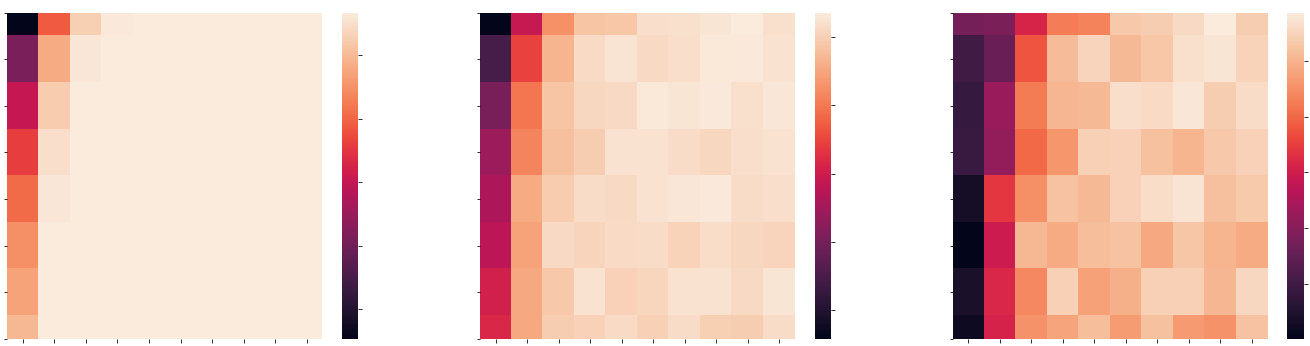

In [386]:
AVG_Train_ROCAUC = GB_RESULTS['train_avg_roc_auc'].values.reshape(len(LR_ARR), len(MAX_DEPTH_ARR))
AVG_Test_ROCAUC = GB_RESULTS['test_avg_roc_auc'].values.reshape(len(LR_ARR), len(MAX_DEPTH_ARR))

LR_ARR = np.round(LR_ARR, 2)

fig, axes = plt.subplots(1,3, figsize=(24,6))

axes[0].set_title("Train Score")
sns.heatmap(AVG_Train_ROCAUC,
            xticklabels=MAX_DEPTH_ARR, yticklabels=LR_ARR,
            ax=axes[0])

axes[1].set_title("Test Score")
sns.heatmap(AVG_Test_ROCAUC,
            xticklabels=MAX_DEPTH_ARR, yticklabels=LR_ARR,
            ax=axes[1])

axes[2].set_title("Test Score / Train Score")
sns.heatmap(AVG_Test_ROCAUC / AVG_Train_ROCAUC,
            xticklabels=MAX_DEPTH_ARR, yticklabels=LR_ARR,
            ax=axes[2])

<div class = "alert alert-block alert-info">

<b>Описание теплокарт выше:</b>
* <b>Ось Х</b> : `max_depth`, максимальная глубина дерева
* <b>Ось Y</b> : `learning_rate`, степень обучения
* <b>Ось Z</b> : метрика ROC AUC

</div>

In [387]:
for i, clf in enumerate(best_gb_est):
    Preds = clf.predict(Exam_X)
    ValPreds = clf.predict(X)
    Probs = clf.predict_proba(Exam_X)
    ValProbs = clf.predict_proba(X)
    
    print(60*"=")
    print(f"{i+1}-й Классификатор")
    print(60*"=")
    
    print("Val Report:\n")
    print(classification_report(y, ValPreds))
    print("Exam Report:\n")
    print(classification_report(Exam_Y, Preds))

1-й Классификатор
Val Report:

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      4834
         1.0       0.80      0.82      0.81       924

    accuracy                           0.94      5758
   macro avg       0.88      0.89      0.89      5758
weighted avg       0.94      0.94      0.94      5758

Exam Report:

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      2594
         1.0       0.29      0.07      0.12       248

    accuracy                           0.90      2842
   macro avg       0.60      0.53      0.53      2842
weighted avg       0.86      0.90      0.88      2842

2-й Классификатор
Val Report:

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97      4834
         1.0       0.82      0.83      0.82       924

    accuracy                           0.94      5758
   macro avg       0.89      0.90      0.90      575

### Сохранение моделей

In [ ]:
MODELS_DIR = "./XGB_GB_Classifiers_FebrauryLogs/"
# os.mkdir(MODELS_DIR)

In [286]:
## Сохраним модели
import time
time_log = "date_" + '_'.join(map(str,time.localtime()[:3])) + \
           "_time_" + ':'.join(map(str, time.localtime()[3:5]))

for i, clf in enumerate(best_est):
    clf.save_model(os.path.join(MODELS_DIR, f"model_{i}__{time_log}.xgbmodel"))

In [ ]:
###================================###
### Опционально : загрузка моделей ###
###================================###
MODELS_DIR = "./XGB_GB_Classifiers_FebrauryLogs/"
###================================================================================================###

# LAST_N_MODELS = 5

# MODEL_NAMES = sorted(os.listdir(MODELS_DIR), key = lambda x: x[10:])[-LAST_N_MODELS:]

# best_gb_est = []
# for model_name in MODEL_NAMES:
#     clf = XGBClassifier()
#     clf.load_model(os.path.join(MODELS_DIR, model_name))
#     best_est.append(clf)
    
###================================================================================================###

### Визуализация важности признаков

In [388]:
FeatureImportances = sorted(zip(Exam_X.columns, clf.feature_importances_), 
                            key = lambda x: x[1], reverse=True)

CorrFI = [fi for fi in FeatureImportances if fi[0].startswith('Corr_')]
InitFI = sorted(set(FeatureImportances) - set(CorrFI), key=lambda x: x[1], reverse=True)

#### Отдельно исходные признаки и попарные корреляции

<div class = "alert alert-block alert-info">
    
> Заметим, что только <b>несколько исходных топ признаков</b> имеют важность больше 0.01, тогда как <b>топ-14 попарных корреляций</b> все имеют важность больше 0.01


</div>

<BarContainer object of 14 artists>

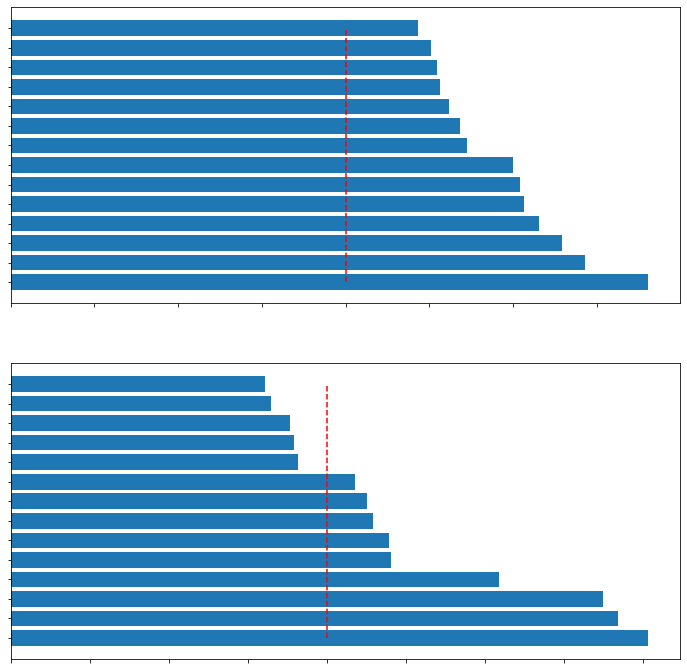

In [389]:
fig, axes = plt.subplots(2,1, figsize=(12,12))

TOP_N = 14

axes[0].vlines(0.01, 1, TOP_N, colors='red', linestyle='dashed')
axes[0].barh(range(1, TOP_N+1), [fi[1] for fi in CorrFI[:TOP_N]],
         tick_label = [fi[0] for fi in CorrFI[:TOP_N]])

axes[1].vlines(0.01, 1, TOP_N, colors='red', linestyle='dashed')
axes[1].barh(range(1, TOP_N+1), [fi[1] for fi in InitFI[:TOP_N]],
         tick_label = [fi[0] for fi in InitFI[:TOP_N]])

#### Общий ТОП признаков

<BarContainer object of 28 artists>

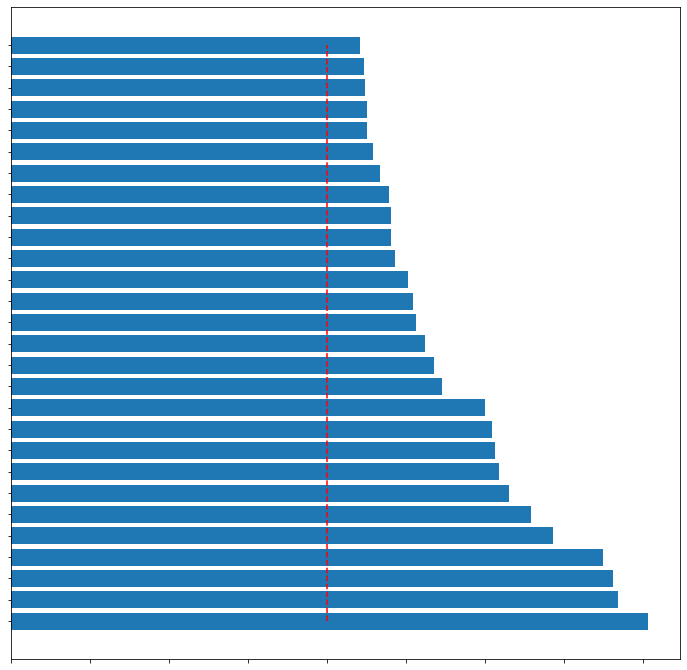

In [390]:
plt.figure(figsize=(12,12))
plt.vlines(0.01, 1, 2*TOP_N, colors='red', linestyle='dashed')
plt.barh(range(1, 2*TOP_N+1), [fi[1] for fi in FeatureImportances[:2*TOP_N]],
         tick_label = [fi[0] for fi in FeatureImportances[:2*TOP_N]])

### Визуализация предсказаний

#### Train Part

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

config = dict({'scrollZoom': True})

import pandas as pd
sens_name_1 = ScaledData.columns[12]
sens_name_2 = ScaledData.columns[13]

Sens_1 = ScaledData[sens_name_1].values
Sens_2 = ScaledData[sens_name_2].values

fig = go.Figure()
fig.add_trace(go.Scatter(x=ScaledData.index, y=Sens_1, name="Вибрация ЗПД (осев.)"))
fig.add_trace(go.Scatter(x=ScaledData.index, y=Sens_2, name="Вибрация ЗПД (рад.)"))
fig.add_traces([
    go.Scatter(x=ScaledData.index,
               y=ScaledData.target.values, 
               fill="tozerox",
               name="Остановки"),
    go.Scatter(x=ScaledData.index,
               y=Probs ,
               fill="tozeroy",
               name="Уровень опасности"),
])

#==========================================================================================#

# fig.update_xaxes(rangeslider_visible=True)
fig.show(config=config)
fig.write_html("Febraury_XGBoost_Results.html", config=config)

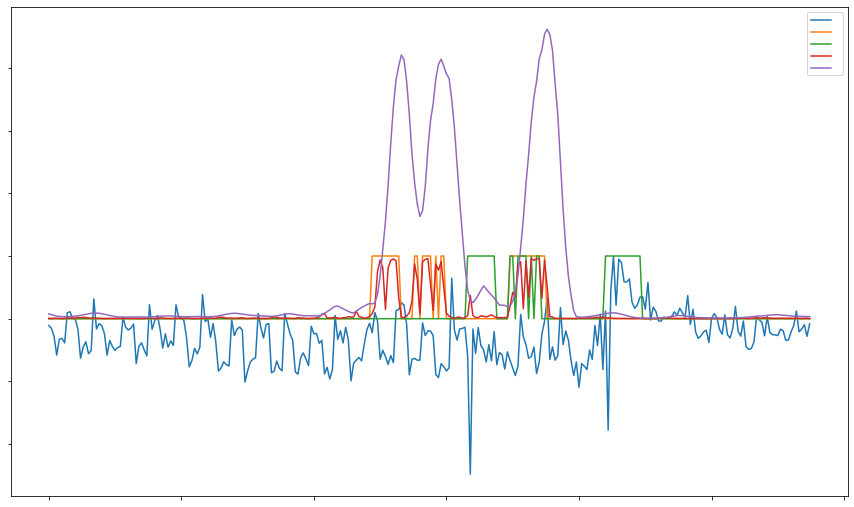

In [391]:
Preds_Series = pd.Series(ValPreds, index=y.index, name='Pred Y')
Probs_Series = pd.Series(ValProbs[:,1], index=y.index, name='Prob Y')
CumProbs_Series = Probs_Series.rolling(window=6).sum().rolling(window=6).mean()
CumProbs_Series.name = 'Cumulative Prob Y'



plt.figure(figsize=(15,9))
border = (9*288//2,11*288//2)
X['Вибрация переднего подшипника двигателя (осевая)'][border[0]:border[1]].plot()
y[border[0]:border[1]].plot()
Val_Data.target[border[0]:border[1]].plot()
# Preds_Series[border[0]:border[1]].plot()
Probs_Series[border[0]:border[1]].plot()
CumProbs_Series[border[0]:border[1]].plot()

plt.legend()

#### Test Part

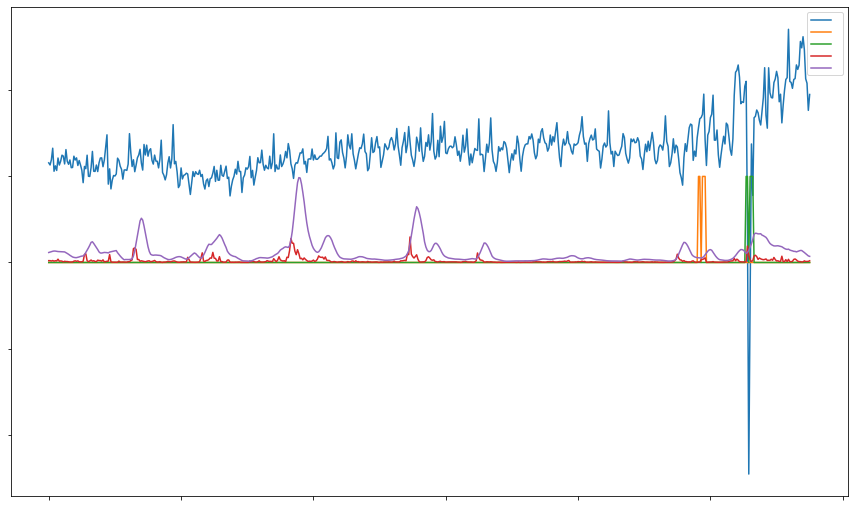

In [392]:
Preds_Series = pd.Series(Preds, index=Exam_Y.index, name='Pred Y')
Probs_Series = pd.Series(Probs[:,1], index=Exam_Y.index, name='Prob Y')
CumProbs_Series = Probs_Series.rolling(window=6).sum().rolling(window=6).mean()
CumProbs_Series.name = 'Cumulative Prob Y'



plt.figure(figsize=(15,9))
border = (1*288,3*288)
Exam_X['Вибрация переднего подшипника двигателя (осевая)'][border[0]:border[1]].plot()
Exam_Y[border[0]:border[1]].plot()
Exam_Data.target[border[0]:border[1]].plot()
# Preds_Series[border[0]:border[1]].plot()
Probs_Series[border[0]:border[1]].plot()
CumProbs_Series[border[0]:border[1]].plot()

plt.legend()

# EOF